In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import cartopy.feature as cfeature
import xskillscore as xs
import ipywidgets as widgets

In [3]:
#historical data
his_prcp_ds = xr.open_zarr(
    "gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/Amon/prc/gr/v20180803",
    chunks={},
    consolidated=True,
)

#projection data
proj_prcp_ds = xr.open_zarr(
    "gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp245/r1i1p1f1/Amon/pr/gr/v20190119",
    chunks={},
    consolidated=True,
)

In [19]:
print("Historical time range:", his_prcp_ds.time.min().values, "to", his_prcp_ds.time.max().values)
print("Projection time range:", proj_prcp_ds.time.min().values, "to", proj_prcp_ds.time.max().values)

print("Coordinates in historical dataset:", list(his_prcp_ds.coords))
print("Coordinates in projection dataset:", list(proj_prcp_ds.coords))

Historical time range: 1850-01-16T12:00:00.000000000 to 2014-12-16T12:00:00.000000000
Projection time range: 2015-01-16T12:00:00.000000000 to 2100-12-16T12:00:00.000000000
Coordinates in historical dataset: ['lat', 'lon', 'time', 'time_bounds']
Coordinates in projection dataset: ['lat', 'lon', 'time', 'time_bounds']


In [4]:
his_prcp = his_prcp_ds['prc']
proj_prcp = proj_prcp_ds['prc']

print("Historical prc stats:")
print("Min:", his_prcp.min().compute().item())
print("Max:", his_prcp.max().compute().item())
print("Mean:", his_prcp.mean().compute().item())
print("Std:", his_prcp.std().compute().item())

print("\nProjection prc stats:")
print("Min:", proj_prcp.min().compute().item())
print("Max:", proj_prcp.max().compute().item())
print("Mean:", proj_prcp.mean().compute().item())
print("Std:", proj_prcp.std().compute().item())

KeyError: "No variable named 'prc'. Did you mean one of ('pr',)?"

In [21]:
print("Historical missing data:", his_prcp_ds['prc'].isnull().sum().compute().item())
print("Projection missing data:", proj_prcp_ds['prc'].isnull().sum().compute().item())

Historical missing data: 0
Projection missing data: 0


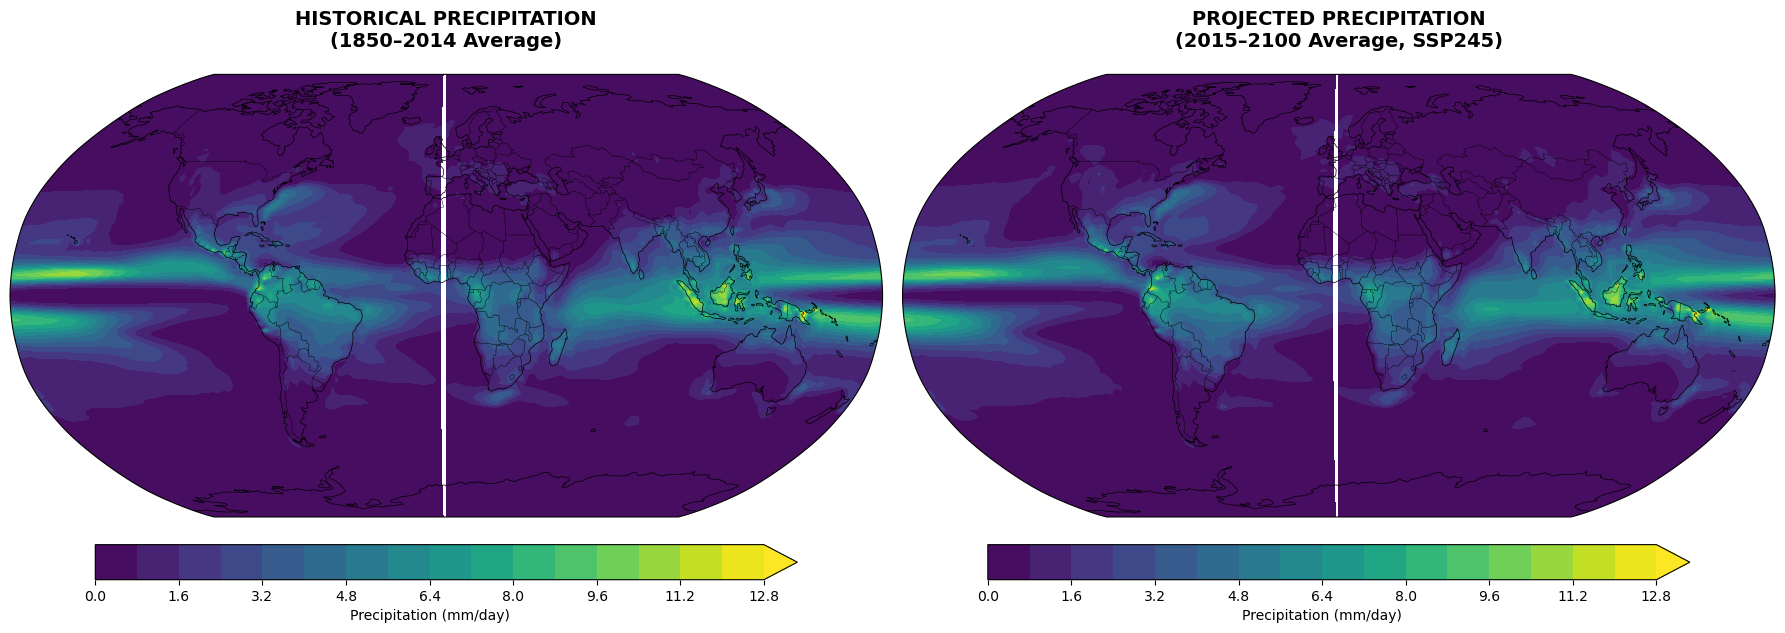

In [ ]:
# This map shows the average daily precipitation from 1995 to 2014.
# It represents the baseline historical climate conditions.

his_avg = his_prcp_ds.sel(time=slice('1850', '2014')).prc.groupby('time.year').mean('time').mean('year') * 86400

# This map shows the projected average daily precipitation for 2041 to 2060 under SSP2-4.5.
# It indicates future changes in rainfall patterns based on model projections.

proj_avg = proj_prcp_ds.sel(time=slice('2015', '2100')).prc.groupby('time.year').mean('time').mean('year') * 86400

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6),
                         subplot_kw={'projection': ccrs.Robinson()})

# Historical plot
ax1 = axes[0]
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax1.add_feature(cfeature.BORDERS, linewidth=0.3)
ax1.set_title('HISTORICAL PRECIPITATION\n(1850–2014 Average)', fontsize=14, fontweight='bold', pad=20)

im1 = ax1.contourf(his_avg.lon, his_avg.lat, his_avg, levels=20, cmap='viridis',
                   transform=ccrs.PlateCarree(), extend='max')
cbar1 = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.05, shrink=0.8)
cbar1.set_label('Precipitation (mm/day)')

# Projected plot
ax2 = axes[1]
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.3)
ax2.set_title('PROJECTED PRECIPITATION\n(2015–2100 Average, SSP245)', fontsize=14, fontweight='bold', pad=20)

im2 = ax2.contourf(proj_avg.lon, proj_avg.lat, proj_avg, levels=20, cmap='viridis',
                   transform=ccrs.PlateCarree(), extend='max')
cbar2 = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.05, shrink=0.8)
cbar2.set_label('Precipitation (mm/day)')
plt.savefig('figs/his_vs_isplProj_prc.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

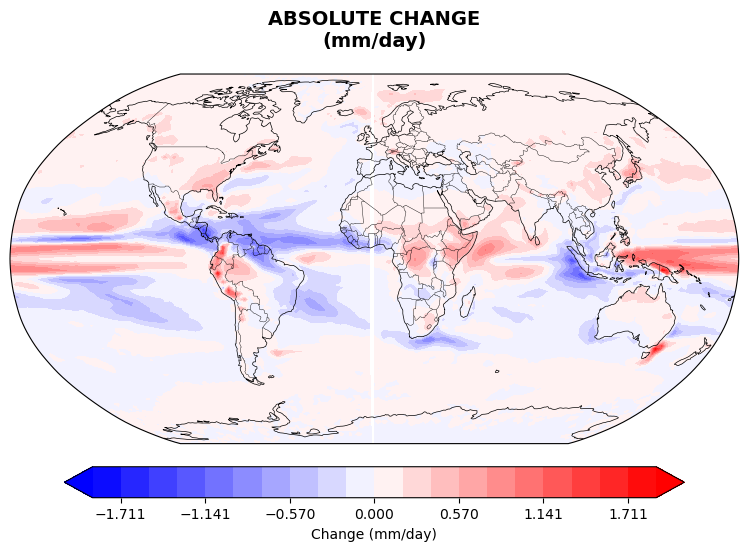

In [23]:
# This map shows the absolute change in daily precipitation between projected and historical periods.
# Positive values indicate increases in rainfall, negative values show decreases.

abs_change = proj_avg - his_avg

fig = plt.figure(figsize=(10, 6))

ax3 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax3.add_feature(cfeature.BORDERS, linewidth=0.3)
ax3.set_title('ABSOLUTE CHANGE\n(mm/day)', fontsize=14, fontweight='bold', pad=20)

max_abs = np.nanmax(np.abs(abs_change))
levels_abs = np.linspace(-max_abs, max_abs, 21)
im3 = ax3.contourf(abs_change.lon, abs_change.lat, abs_change, levels=levels_abs, cmap='bwr', transform=ccrs.PlateCarree(), extend='both')
cbar3 = plt.colorbar(im3, ax=ax3, orientation='horizontal', pad=0.05, shrink=0.8)
cbar3.set_label('Change (mm/day)')
plt.savefig('figs/his_isplProj_prc_abs_change.png', dpi=300, bbox_inches='tight')
plt.show()

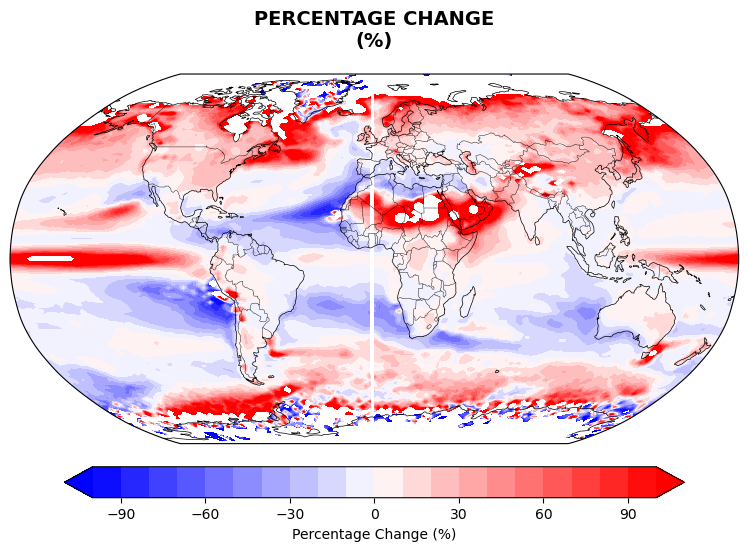

In [24]:
# This map shows the percentage change in daily precipitation relative to the historical average.
# It highlights areas with substantial increases or decreases in rainfall intensity.

pct_change = (abs_change / his_avg) * 100
pct_clip = pct_change.where(np.abs(pct_change) < 200, np.nan)

fig = plt.figure(figsize=(10, 6))

ax4 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax4.add_feature(cfeature.BORDERS, linewidth=0.3)
ax4.set_title('PERCENTAGE CHANGE\n(%)', fontsize=14, fontweight='bold', pad=20)

levels_pct = np.linspace(-100, 100, 21)
im4 = ax4.contourf(pct_clip.lon, pct_clip.lat, pct_clip, levels=levels_pct, cmap='bwr', transform=ccrs.PlateCarree(), extend='both')
cbar4 = plt.colorbar(im4, ax=ax4, orientation='horizontal', pad=0.05, shrink=0.8)
cbar4.set_label('Percentage Change (%)')
plt.savefig('figs/his_isplProj_prc_%change.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
# Summary stats
print("\n=== PRECIPITATION SUMMARY ===")
print(f"Historical avg: {float(his_avg.mean()):.2f} mm/day")
print(f"Projected avg: {float(proj_avg.mean()):.2f} mm/day")
print(f"Absolute change avg: {float(abs_change.mean()):.3f} mm/day")
print(f"Percentage change avg: {float(pct_change.mean()):.1f}%")

# Regional changes
trop_mask = (his_avg.lat >= -20) & (his_avg.lat <= 20)
high_lat_mask = (his_avg.lat >= 60) | (his_avg.lat <= -60)
print(f"Tropical (20°S-20°N) change: {float(abs_change.where(trop_mask).mean()):.3f} mm/day")
print(f"High latitudes (>60°) change: {float(abs_change.where(high_lat_mask).mean()):.3f} mm/day")


=== PRECIPITATION SUMMARY ===
Historical avg: 1.10 mm/day
Projected avg: 1.11 mm/day
Absolute change avg: 0.006 mm/day
Percentage change avg: inf%
Tropical (20°S-20°N) change: -0.012 mm/day
High latitudes (>60°) change: 0.019 mm/day


In [26]:
ssp = pd.read_csv("ssp245.csv")
ssp_omon = ssp[(ssp["table_id"] == "Omon") & (ssp["grid_label"] == "gn")]

In [27]:
zs1 = ssp_omon[ssp_omon['institution_id'] == "NOAA-GFDL"].iloc[0]['zstore']
zs2 = ssp_omon[ssp_omon['institution_id'] == "NCC"].iloc[0]['zstore']

In [28]:
ds1 = xr.open_zarr(zs1, chunks = {}, consolidated=True)
ds2 = xr.open_zarr(zs2, chunks = {}, consolidated=True)

In [29]:
# Interactive time step slider for global SST maps

def plot_sst_time_step(time_idx):
	fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.Robinson()})

	# ds1 plot
	im1 = axes[0].pcolormesh(ds1['lon'], ds1['lat'], ds1['tos'].isel(time=time_idx), cmap='coolwarm', transform=ccrs.PlateCarree())
	axes[0].set_title(f'ds1: GFDL-CM4: TOS (time step {time_idx})')
	axes[0].add_feature(cfeature.COASTLINE)
	plt.colorbar(im1, ax=axes[0], orientation='horizontal', pad=0.05, label='Sea Surface Temp (°C)')

	# ds2 plot
	im2 = axes[1].pcolormesh(ds2['longitude'], ds2['latitude'], ds2['tos'].isel(time=time_idx), cmap='coolwarm', transform=ccrs.PlateCarree())
	axes[1].set_title(f'ds2: NorESM2-LM: TOS (time step {time_idx})')
	axes[1].add_feature(cfeature.COASTLINE)
	plt.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.05, label='Sea Surface Temp (°C)')

	plt.tight_layout()
	plt.show()

widgets.interactive(
	plot_sst_time_step,
	time_idx=widgets.IntSlider(min=0, max=len(ds1['time'])-1, step=1, value=0, description='Time Step')
)

interactive(children=(IntSlider(value=0, description='Time Step', max=1031), Output()), _dom_classes=('widget-…

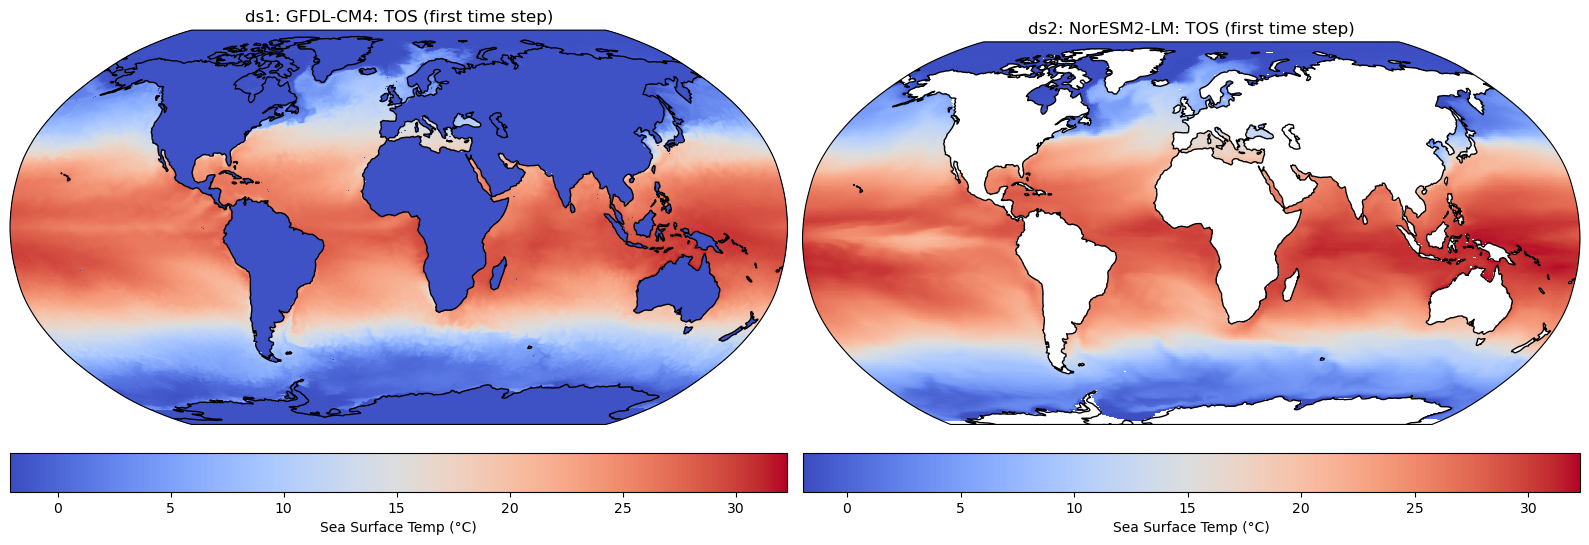

In [30]:
# Plot the global sea surface temperature (SST) maps for the first time step for both datasets

fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={'projection': ccrs.Robinson()})

# ds1 plot
im1 = axes[0].pcolormesh(ds1['lon'], ds1['lat'], ds1['tos'].isel(time=0), cmap='coolwarm', transform=ccrs.PlateCarree())
axes[0].set_title('ds1: GFDL-CM4: TOS (first time step)')
axes[0].add_feature(cfeature.COASTLINE)
plt.colorbar(im1, ax=axes[0], orientation='horizontal', pad=0.05, label='Sea Surface Temp (°C)')

# ds2 plot
im2 = axes[1].pcolormesh(ds2['longitude'], ds2['latitude'], ds2['tos'].isel(time=0), cmap='coolwarm', transform=ccrs.PlateCarree())
axes[1].set_title('ds2: NorESM2-LM: TOS (first time step)')
axes[1].add_feature(cfeature.COASTLINE)
plt.colorbar(im2, ax=axes[1], orientation='horizontal', pad=0.05, label='Sea Surface Temp (°C)')

plt.tight_layout()
plt.savefig('figs/first_time_step_sst.png', dpi=300, bbox_inches='tight')
plt.show()

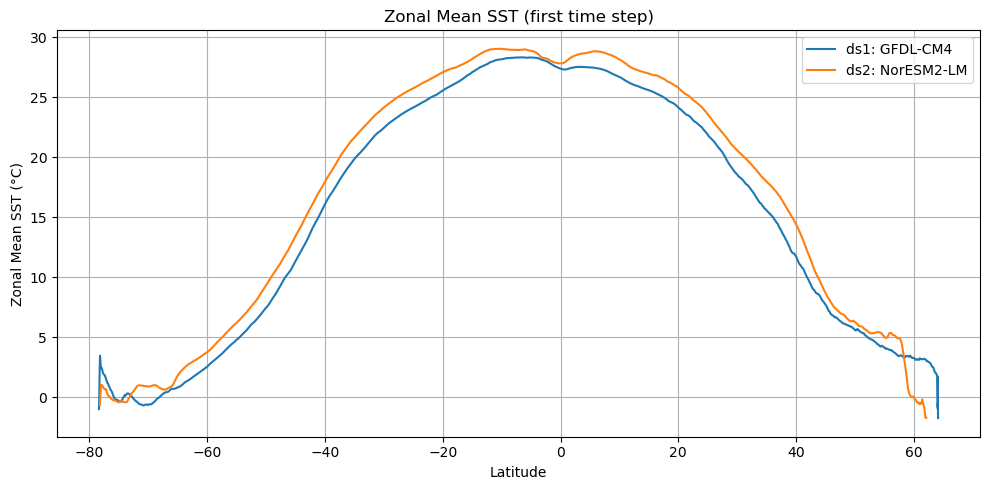

In [31]:
# 2. Zonal mean (mean over longitude) SST for the first time step
zonal_mean_ds1 = ds1['tos'].isel(time=0).mean(dim='x')
zonal_mean_ds2 = ds2['tos'].isel(time=0).mean(dim='i')

plt.figure(figsize=(10, 5))
plt.plot(ds1['lat'][:,0], zonal_mean_ds1, label='ds1: GFDL-CM4')
plt.plot(ds2['latitude'][:,0], zonal_mean_ds2, label='ds2: NorESM2-LM')
plt.xlabel('Latitude')
plt.ylabel('Zonal Mean SST (°C)')
plt.title('Zonal Mean SST (first time step)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('figs/zonal_mean_sst.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
ssp = pd.read_csv("web/ssp245.csv")
sspb

,mip,institution,model,ensemble,realm,variable,grid,zstore,version
0,ScenarioMIP,CAS,FGOALS-f3-L,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/s...,20191008
1,ScenarioMIP,CAS,FGOALS-f3-L,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/s...,20200221
2,ScenarioMIP,CAS,FGOALS-f3-L,r3i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-f3-L/s...,20200220
3,ScenarioMIP,CAS,FGOALS-g3,r1i1p1f1,Amon,clt,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp...,20190818
4,ScenarioMIP,CAS,FGOALS-g3,r1i1p1f1,Amon,prc,gn,gs://cmip6/CMIP6/ScenarioMIP/CAS/FGOALS-g3/ssp...,20190818
...,...,...,...,...,...,...,...,...,...
238,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,r1i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,20180701
239,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,r2i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,20180701
240,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,r2i1p1f1,Omon,tos,gn,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,20180701
241,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,r3i1p1f1,Amon,tas,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,20180701


In [6]:
import gcsfs

fs = gcsfs.GCSFileSystem()

# List files in the path to check access
print(fs.ls("climatebench/observations/preprocessed/pr/"))


['climatebench/observations/preprocessed/pr/pr_noaa_gpcp.zarr']
